# Quora Question Pair Similarity

## Business Problem
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

## Problem Statement
- Identify which questions asked on Quora are duplicates of questions that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

## Source
- Source: https://www.kaggle.com/c/quora-question-pairs
        
#### Useful links:
- Discussions: https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1: https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2: https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30
        
## Real World/Business Objectives and Constraints
- The cost of a mis-classification can be very high.
- You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
- No strict latency concerns.
- Interpretability is partially important.

## Data Overview
- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290

## Example Data point
"id","qid1","qid2","question1","question2","is_duplicate"

"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"

"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"

"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"

"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

## Mapping the real world problem to an ML problem
It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

## Performance Metric
- log-loss- In order to calculate log-loss, the classifier must assign a probability to each class rather than simply yielding the most likely class. Log Loss quantifies the accuracy of a classifier by penalizing false classifications.
- Binary Confusion Matrix- A used technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class.
- Since we will are dealing with probability scores, it is best to choose log-loss as our metric and the Binary confusion matrix will provide numbers of metrics like TPR, FPR, TNR, FNR, Precision, and Recall.

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import pickle
import distance
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import gensim
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from fuzzywuzzy import fuzz
from scipy.sparse import hstack
from itertools import product
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [2]:
DATAPATH = r"C:\Users\sush\OneDrive\Desktop\ML projects\Quora Question Pair Similarity"
DATA_FILE = r"train.csv"
DATA_NEW = r"TRAIN_NEW.csv"
DATA_UPDATED = r"TRAIN_UPDATED.csv"
DATA_ADV = r"TRAIN_ADV.csv"
DATA_ADV2 = r"TRAIN_ADV2.csv"

## Reading data

In [3]:
data_raw = pd.read_csv(os.path.join(DATAPATH, DATA_FILE))
data_raw.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print("Shape of data = "+str(data_raw.shape))

Shape of data = (404290, 6)


## Checking and removing null value data points

In [5]:
data_raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
#printing indices of points which contain null values
nullIndices = []
for index, textinfo in data_raw.iterrows():
    if type(textinfo["question1"]) is not str or type(textinfo["question2"]) is not str:
        print(index)
        nullIndices.append(index)

105780
201841
363362


In [7]:
data_raw.drop(nullIndices, axis = 0, inplace = True)
data_raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Checking label counts and balancing the data

In [8]:
data_raw['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [9]:
label_name = data_raw['is_duplicate'].map({0:"Not-Duplicate", 1:"Duplicate"})
label_name.value_counts()

Not-Duplicate    255024
Duplicate        149263
Name: is_duplicate, dtype: int64

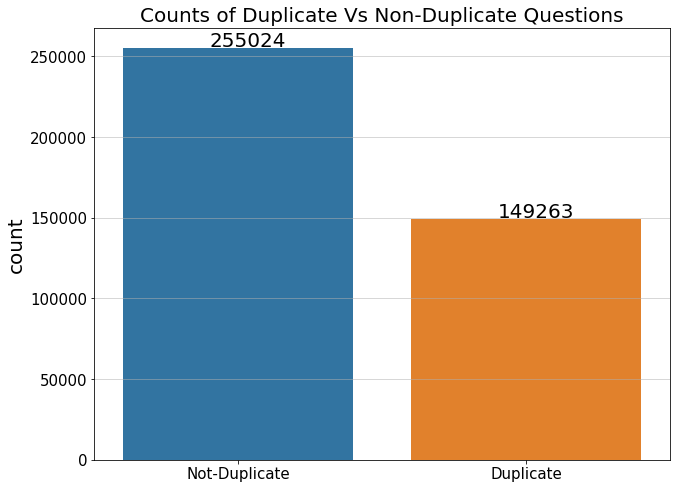

In [10]:
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Counts of Duplicate Vs Non-Duplicate Questions", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
plt.grid(linestyle='-', linewidth=0.5)
axes.tick_params(labelsize = 15)
sns.countplot(list(label_name), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.3, i.get_height()+1000, str(round(i.get_height(), 2)), fontsize=20, color='black')
plt.show()

### Observation:
- Number of data points which contains non duplicate questions are very high as compared to data points which contains duplicate questions.
- We have enough number of data points, so we will remove 105700 non duplicate data points from our data to balance duplicate and non duplicate questions.

In [11]:
data_raw_nonDup = data_raw[data_raw['is_duplicate'] == 0]
data_raw_Dup = data_raw[data_raw['is_duplicate'] == 1]
print("Non Dup Ques Shape = "+str(data_raw_nonDup.shape))
print("Non Dup Ques Shape = "+str(data_raw_Dup.shape))

Non Dup Ques Shape = (255024, 6)
Non Dup Ques Shape = (149263, 6)


In [12]:
totalFrame = [data_raw_nonDup.sample(data_raw_nonDup.shape[0]-105700), data_raw_Dup]
data_new = pd.concat(totalFrame)
data_new.sort_values('id', axis=0, ascending=True, inplace=True)
data_new.reset_index(drop = True, inplace = True)
data_new.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
1,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
2,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
3,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
4,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [13]:
data_new['is_duplicate'].value_counts()

0    149324
1    149263
Name: is_duplicate, dtype: int64

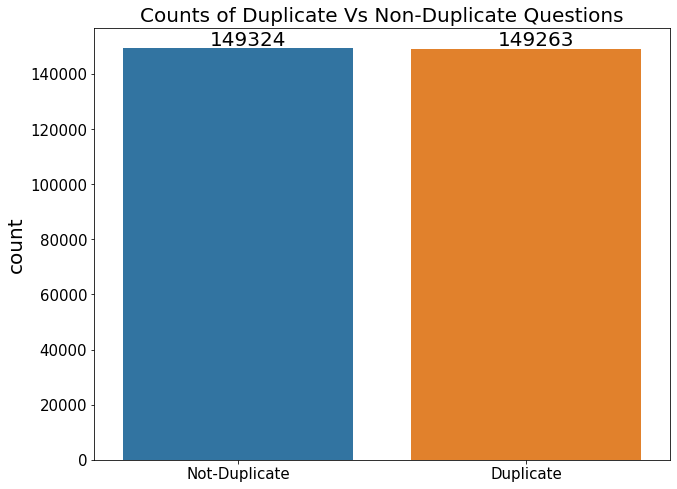

In [14]:
label_name = data_new['is_duplicate'].map({0:"Not-Duplicate", 1:"Duplicate"})
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Counts of Duplicate Vs Non-Duplicate Questions", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
axes.tick_params(labelsize = 15)
sns.countplot(list(label_name), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.3, i.get_height()+1000, str(round(i.get_height(), 2)), fontsize=20, color='black')
plt.show()

In [15]:
#saving new data frame
data_new.to_csv(os.path.join(DATAPATH, DATA_NEW), index = False)

## Number of Unique Questions

In [22]:
data_balanced = pd.read_csv(os.path.join(DATAPATH, DATA_NEW))
data_balanced['is_duplicate'].value_counts()

0    149324
1    149263
Name: is_duplicate, dtype: int64

In [23]:
print("Shape of data = "+str(data_balanced.shape))

Shape of data = (298587, 6)


In [24]:
data_balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
1,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
2,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
3,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
4,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [25]:
total_ques = pd.Series(data_balanced['qid1'].tolist() + data_balanced['qid2'].tolist()) 
# So, now 'total_ques' contains ids of both 'qid1' and 'qid2' in one big array.
unique_ques = len(np.unique(total_ques))
non_unique_ques = np.sum(total_ques.value_counts()>1) #now, the value_counts() have the values greater than one for all those 
# elements who are occurring more than once. So, this gives us the count of all the number of repeated questions.
print("Total number of unique questions = "+str(unique_ques))
print("Total number of unique questions that appeared more than one time = "+str(non_unique_ques))
print("Question which appeared most number of times = "+str(max(total_ques.value_counts())))

Total number of unique questions = 391027
Total number of unique questions that appeared more than one time = 79178
Question which appeared most number of times = 104


## Checking for Duplicates

In [26]:
data_duplicates = data_balanced[['qid1','qid2', 'question1','question2','is_duplicate']].groupby(['qid1', 'qid2']).count()
print("Numbr of duplicate entries = "+str(data_balanced.shape[0] - data_duplicates.shape[0]))

Numbr of duplicate entries = 0


## Plotting Occurrence of each question

Text(0, 0.5, 'Number of questions')

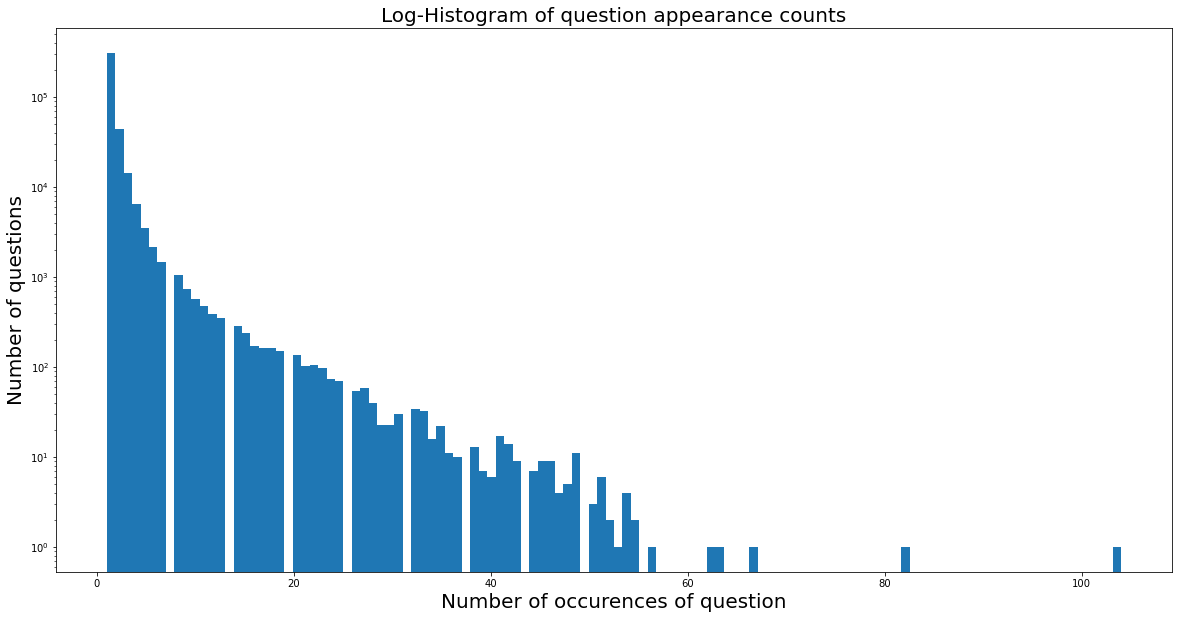

In [27]:
plt.figure(figsize=(20, 10))
plt.hist(total_ques.value_counts(), bins=120) 
# created 120 bins of the occurrences of each of the question. Here, total_ques.value_counts() will give a pandas series which is a sort of dictionary. Here, keys of 
#this series is an id of a question and value is its occurrences. Now, the highest occurrences of a question is 104 and lowest is
#1. Now, we have divided this range of 1 to 104 into 120 equal bins and counted how many values fall in each bin which are 
#reflected on y-axis. Let say the first bin is from 1 to 1.7, so now we have counted how many questions are occurring one time 
#and plotted the same on y-axis and so on.

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts', fontsize = 20)

plt.xlabel('Number of occurences of question', fontsize = 20)

plt.ylabel('Number of questions', fontsize = 20)

## Basic Featurization
Let us now construct a few features like:
1. Freq_qid1 = Frequency of qid1's(How many times question1 is repeating in whole dataset)
2. Freq_qid2 = Frequency of qid2's(How many times question2 is repeating in whole dataset)
3. Q1_len = Length of question1(Count of total number of letters including spaces)
4. Q2_len = Length of question2(Count of total number of letters including spaces)
5. Q1_n_words = Number of words in Question 1(Count of total number of words)
6. Q2_n_words = Number of words in Question 2(Count of total number of words)
7. Word_Common = (Number of common unique words in Question 1 and Question 2)
8. Word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
9. Word_Share = (word_common)/(word_Total)
10. Freq_q1+Freq_q2 = Self Explanatory
12. Freq_q1-Freq_q2 = Self Explanatory(Here we have taken Absolute Difference)

In [28]:
data_balanced2 = pd.read_csv(os.path.join(DATAPATH, DATA_NEW))
data_balanced2.shape

(298587, 6)

In [29]:
data_balanced2['Freq_qid1'] = data_balanced2.groupby('qid1')['qid1'].transform('count')
data_balanced2['Freq_qid2'] = data_balanced2.groupby('qid2')['qid2'].transform('count')

data_balanced2['Q1_len'] = data_balanced2['question1'].apply(lambda x: len(x))
data_balanced2['Q2_len'] = data_balanced2['question2'].apply(lambda x: len(x))

data_balanced2['Q1_n_words'] = data_balanced2['question1'].apply(lambda x: len(x.split(" ")))
data_balanced2['Q2_n_words'] = data_balanced2['question2'].apply(lambda x: len(x.split(" ")))

def Word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
data_balanced2['Word_Common'] = data_balanced2.apply(Word_Common, axis = 1)

def Word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
data_balanced2['Word_Total'] = data_balanced2.apply(Word_Total, axis = 1)

data_balanced2['Word_Share'] = data_balanced2['Word_Common']/data_balanced2['Word_Total']

data_balanced2['Freq_q1+Freq_q2'] = data_balanced2['Freq_qid1'] + data_balanced2['Freq_qid2']

data_balanced2['Freq_q1-Freq_q2'] = abs(data_balanced2['Freq_qid1'] - data_balanced2['Freq_qid2'])

data_balanced2.to_csv(os.path.join(DATAPATH, DATA_UPDATED), index = False)

data_balanced2.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2
0,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,3,1,51,88,8,13,4.0,20.0,0.200000,4,2
1,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
2,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
3,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
4,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0


## Exploring word_share & word_common features

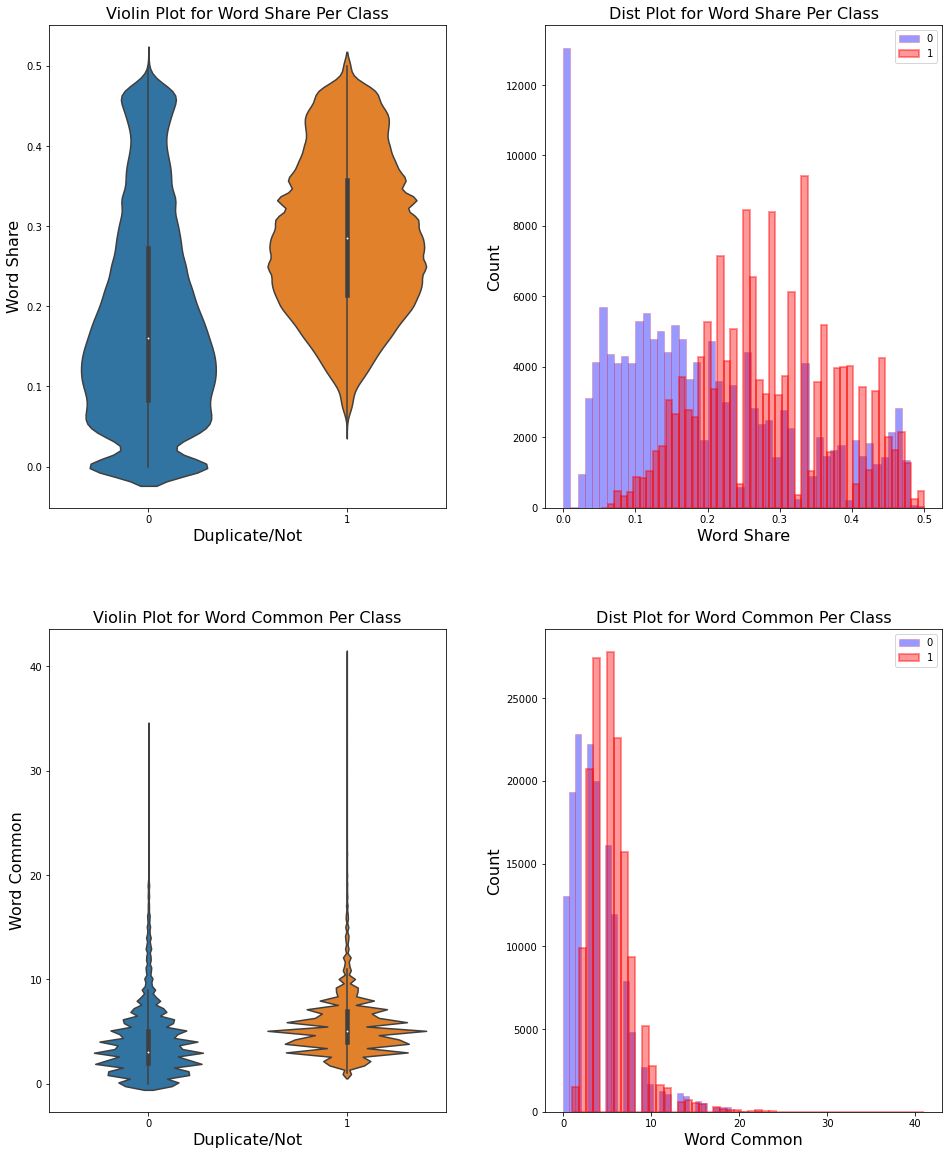

In [30]:
plt.figure(figsize=(16, 20))

plt.subplot(2,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Word_Share', data = data_balanced2)
plt.title("Violin Plot for Word Share Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Word Share", fontsize = 16)

plt.subplot(2,2,2)
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 0]['Word_Share'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="r", linewidth=0.5))
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 1]['Word_Share'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Word Share Per Class", fontsize = 16)
plt.xlabel("Word Share", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(2,2,3)
sns.violinplot(x = 'is_duplicate', y = 'Word_Common', data = data_balanced2)
plt.title("Violin Plot for Word Common Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Word Common", fontsize = 16)

plt.subplot(2,2,4)
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 0]['Word_Common'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="r", linewidth=0.5))
sns.distplot(data_balanced2[data_balanced2['is_duplicate'] == 1]['Word_Common'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Word Common Per Class", fontsize = 16)
plt.xlabel("Word Common", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplots_adjust(hspace = 0.25, wspace = 0.25)
plt.show()

## Pre-processing of Question Text
Preprocessing:
- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [31]:
data_new = pd.read_csv(os.path.join(DATAPATH, DATA_UPDATED))
data_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2
0,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,3,1,51,88,8,13,4.0,20.0,0.200000,4,2
1,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
2,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
3,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
4,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0


In [32]:
stemmer = SnowballStemmer("english")
stopWords = stopwords.words("english")
stopWords.remove('not')
stopWords.remove('no')
stopWords.remove('against')
stopWords.remove('because')
stopWords.remove('while')
stopWords.remove('why')
stopWords.remove('how')
stopWords.remove('can')

def preprocessing_text(txt):
    txt = txt.lower()
    txt = txt.replace(",000,000", "m").replace(",000","k").replace("′", "'").replace("’", "'").replace("can't", "cannot")\
             .replace("don't", "do not").replace("isn't", "is not").replace("you're", "you are").replace("you've","you have")\
             .replace("you'll", "you will").replace("that'll",'that will').replace("should've", "should have")\
             .replace("aren't", "are not").replace("couldn't", "could not").replace("didn't", "did not")\
             .replace("doesn't", "does not").replace("hadn't", "had not").replace("hasn't", "has not")\
             .replace("haven't", "have not").replace("mustn't", "must not").replace("wasn't", "was not")\
             .replace("i'm", "i am").replace("he's", "he is").replace("she's", "she is").replace("ain't", "am not")\
             .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")\
             .replace("'ll", " will").replace("'ve", " have").replace("it's", "it is")
    
    txt = re.sub('[^A-Za-z]+', ' ', txt) #removing html tags
    txt = re.sub('[?|!|\'|"|#]','',txt) #removing punctuations
    txt = re.sub('[.|,|)|(|\|/]','',txt) #removing punctuations
    
    txt = word_tokenize(txt) #it will tokenize all the words automatically
    
    txt = ' '.join(str(stemmer.stem(j)) for j in txt if j not in stopWords and len(j)!=1)  #stemming and removing stop words
    
    return txt

data_new['question1'] = data_new['question1'].apply(preprocessing_text)
data_new['question2'] = data_new['question2'].apply(preprocessing_text)

In [33]:
data_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,Q1_n_words,Q2_n_words,Word_Common,Word_Total,Word_Share,Freq_q1+Freq_q2,Freq_q1-Freq_q2
0,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,3,1,51,88,8,13,4.0,20.0,0.200000,4,2
1,2,5,6,how can increas speed internet connect while u...,how can internet speed increas hack dns,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
2,3,7,8,whi mental lone how can solv,find remaind math math divid,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
3,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
4,5,11,12,astrolog capricorn sun cap moon cap rise say,tripl capricorn sun moon ascend capricorn say,1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0


## Advanced Featurization

Features:

- CWC_Min : Ratio of common_word_count to min length of word count of Q1 and Q2
- CWC_Min = common_word_count / (min(len(q1_words), len(q2_words))

- CWC_Max : Ratio of common_word_count to max length of word count of Q1 and Q2
- CWC_Max = common_word_count / (max(len(q1_words), len(q2_words))

- Last_Word_Equality : Check if last word of both questions is equal or not
- Last_Word_Equality = int(q1_tokens[-1] == q2_tokens[-1])


- First_Word_Equality : Check if First word of both questions is equal or not
- First_Word_Equality = int(q1_tokens[0] == q2_tokens[0])


- Abs_Len_Diff : Abs. length difference
- Abs_Len_Diff = abs(len(q1_tokens) - len(q2_tokens))


- Mean_Len : Average Token Length of both Questions
- Mean_Len = (len(q1_tokens) + len(q2_tokens))/2


- Fuzz_Ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- Fuzz_Partial_Ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- Token_Sort_Ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

- Token_Set_Ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

- Longest_Substr_Ratio : Ratio of length of longest common substring to min length of token count of Q1 and Q2
- longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [34]:
SAFE_DIV = 0.0001  #saving from dividing by 0.

def createAdvancedFeatures(ques1, ques2):
    featureValues = [0.0]*11
    
    ques1_words = ques1.split()
    ques2_words = ques2.split()
    
    if len(ques1_words) == 0 or len(ques2_words) == 0:
        return featureValues
    
    ques1_words_set = set(ques1.split())
    ques2_words_set = set(ques2.split())
    
    featureValues[0] = len(ques1_words_set.intersection(ques2_words_set)) / (min(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
    featureValues[1] = len(ques1_words_set.intersection(ques2_words_set)) / (max(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
    featureValues[2] = int(ques1_words[-1] == ques2_words[-1])
    featureValues[3] = int(ques1_words[0] == ques2_words[0])
    featureValues[4] = abs(len(ques1_words) - len(ques2_words))
    featureValues[5] = (len(ques1_words) + len(ques2_words))/2
    featureValues[6] = fuzz.ratio(ques1, ques2)
    featureValues[7] = fuzz.partial_ratio(ques1, ques2)
    featureValues[8] = fuzz.token_sort_ratio(ques1, ques2)
    featureValues[9] = fuzz.token_set_ratio(ques1, ques2)
    
    strs = list(distance.lcsubstrings(ques1, ques2)) # https://github.com/doukremt/distance/blob/master/distance/_lcsubstrings.py
    if len(strs) == 0:
        featureValues[10] = 0
    else:
        featureValues[10] = len(strs[0]) / (min(len(ques1), len(ques1)) + SAFE_DIV)
        
    return featureValues

In [35]:
advFeatures = data_new.apply(lambda x: createAdvancedFeatures(x["question1"], x["question2"]), axis=1)

data_new["CWC_Min"] = list(map(lambda x: x[0], advFeatures))
data_new["CWC_Max"] = list(map(lambda x: x[1], advFeatures))
data_new["Last_Word_Equality"] = list(map(lambda x: x[2], advFeatures))
data_new["First_Word_Equality"] = list(map(lambda x: x[3], advFeatures))
data_new["Abs_Len_Diff"] = list(map(lambda x: x[4], advFeatures))
data_new["Mean_Len"] = list(map(lambda x: x[5], advFeatures))
data_new["Fuzz_Ratio"] = list(map(lambda x: x[6], advFeatures))
data_new["Fuzz_Partial_Ratio"] = list(map(lambda x: x[7], advFeatures))
data_new["Token_Sort_Ratio"] = list(map(lambda x: x[8], advFeatures))
data_new["Token_Set_Ratio"] = list(map(lambda x: x[9], advFeatures))
data_new["Longest_Substr_Ratio"] = list(map(lambda x: x[10], advFeatures))

data_new.fillna("")
data_new.to_csv(os.path.join(DATAPATH, DATA_ADV), index = False)

In [36]:
data_adv = pd.read_csv(os.path.join(DATAPATH, DATA_ADV))
#removing rows which contain NaN values
nullIndices = []
for index, textinfo in data_adv.iterrows():
    if type(textinfo["question1"]) is not str or type(textinfo["question2"]) is not str:
        nullIndices.append(index)

data_adv.drop(nullIndices, axis = 0, inplace = True)
data_adv.reset_index(drop = True, inplace = True)
data_adv.isnull().sum()

id                      0
qid1                    0
qid2                    0
question1               0
question2               0
is_duplicate            0
Freq_qid1               0
Freq_qid2               0
Q1_len                  0
Q2_len                  0
Q1_n_words              0
Q2_n_words              0
Word_Common             0
Word_Total              0
Word_Share              0
Freq_q1+Freq_q2         0
Freq_q1-Freq_q2         0
CWC_Min                 0
CWC_Max                 0
Last_Word_Equality      0
First_Word_Equality     0
Abs_Len_Diff            0
Mean_Len                0
Fuzz_Ratio              0
Fuzz_Partial_Ratio      0
Token_Sort_Ratio        0
Token_Set_Ratio         0
Longest_Substr_Ratio    0
dtype: int64

In [37]:
print("Shape of data = "+str(data_adv.shape))

Shape of data = (298417, 28)


In [38]:
data_adv['is_duplicate'].value_counts()

1    149248
0    149169
Name: is_duplicate, dtype: int64

In [39]:
data_adv.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,...,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,3,1,51,88,...,0.399996,0.0,0.0,5.0,7.5,62.0,94.0,62.0,89.0,0.838707
1,2,5,6,how can increas speed internet connect while u...,how can internet speed increas hack dns,0,1,1,73,59,...,0.555549,0.0,1.0,2.0,8.0,53.0,59.0,70.0,87.0,0.192307
2,3,7,8,whi mental lone how can solv,find remaind math math divid,0,1,1,50,65,...,0.000000,0.0,0.0,1.0,5.5,25.0,30.0,18.0,20.0,0.071428
3,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0,3,1,76,39,...,0.199998,0.0,0.0,5.0,7.5,24.0,50.0,43.0,53.0,0.109091
4,5,11,12,astrolog capricorn sun cap moon cap rise say,tripl capricorn sun moon ascend capricorn say,1,1,1,86,90,...,0.571420,1.0,0.0,1.0,7.5,72.0,70.0,67.0,77.0,0.340908


## Plotting Word Clouds of words in duplicate and non-duplicate questions

#### For Duplicate Questions

In [40]:
#duplicate questions only
freq_dict = dict()
for q1 in data_adv[data_adv['is_duplicate'] == 1]['question1']:
    for word in q1.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
for q2 in data_adv[data_adv['is_duplicate'] == 1]['question2']:
    for word in q2.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
feat_count_sorted = dict(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True))
count_data = {"Words":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
count_df[:10]

,Words,Count
0,how,90037
1,can,47446
2,best,34485
3,whi,33052
4,get,16109
5,india,13182
6,way,12356
7,quora,12332
8,not,10843
9,peopl,10783


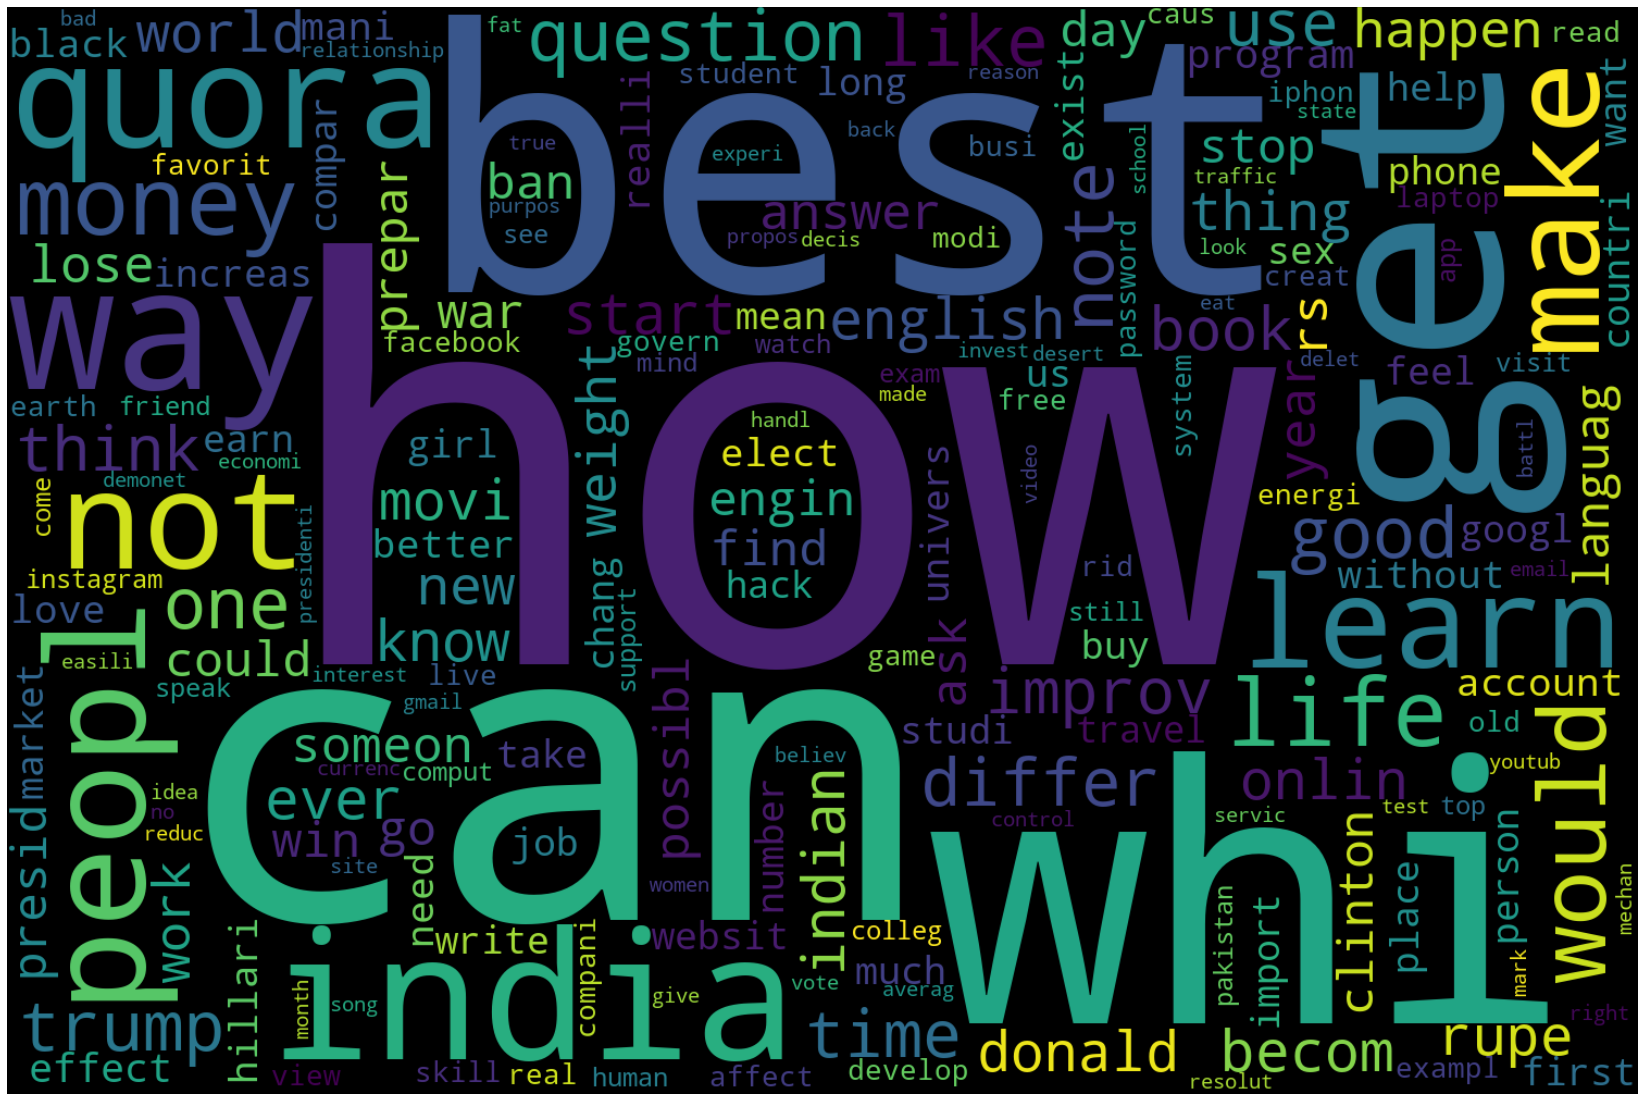

In [41]:
worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=freq_dict)
plt.figure(figsize=(30,20))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

#### For Non-Duplicate Questions

In [42]:
#Non-duplicate questions only
freq_dict = dict()
for q1 in data_adv[data_adv['is_duplicate'] == 0]['question1']:
    for word in q1.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
for q2 in data_adv[data_adv['is_duplicate'] == 0]['question2']:
    for word in q2.split(" "):
        freq_dict[word] = freq_dict.get(word, 0) + 1
feat_count_sorted = dict(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True))
count_data = {"Words":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
count_df[:10]

,Words,Count
0,how,76806
1,can,41629
2,whi,29854
3,best,21270
4,not,18053
5,get,16500
6,use,12281
7,like,12046
8,good,10256
9,differ,10209


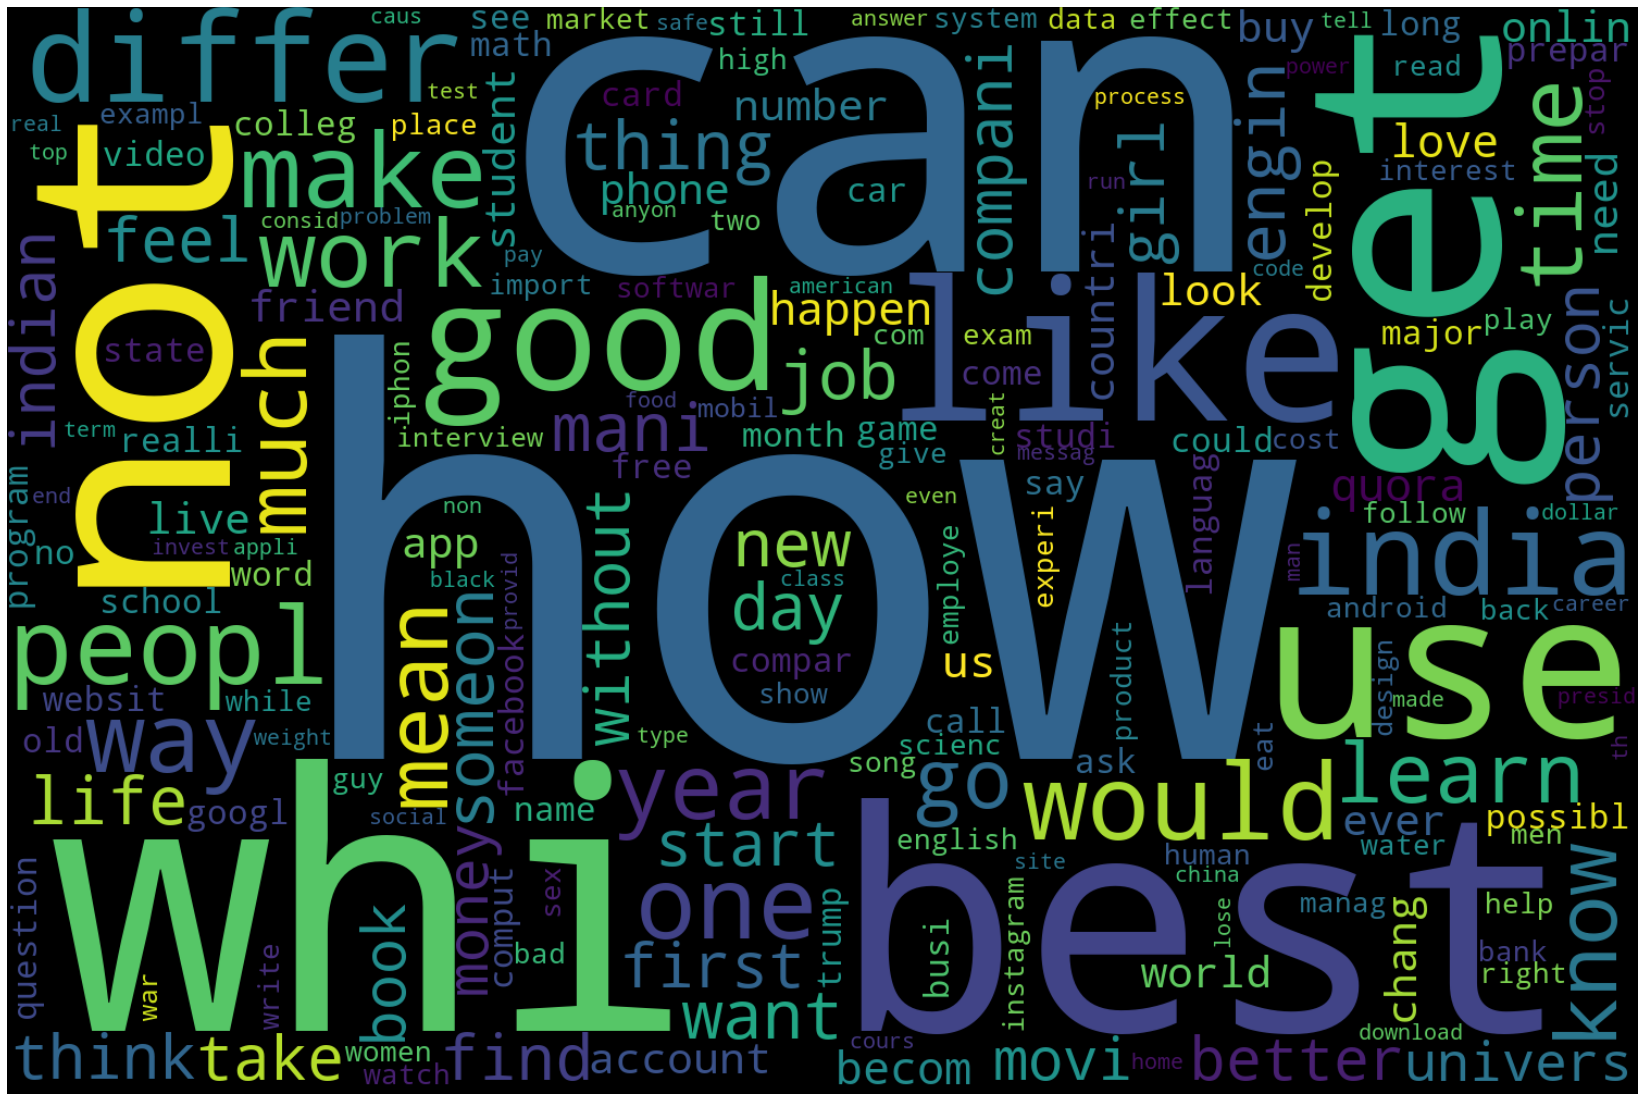

In [43]:
worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=freq_dict)
plt.figure(figsize=(30,20))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

In [44]:
#saving new dataframe
data_adv.to_csv(os.path.join(DATAPATH, DATA_ADV2), index = False)

## Analysing Few Features

In [45]:
data_adv2 = pd.read_csv(os.path.join(DATAPATH, DATA_ADV2))

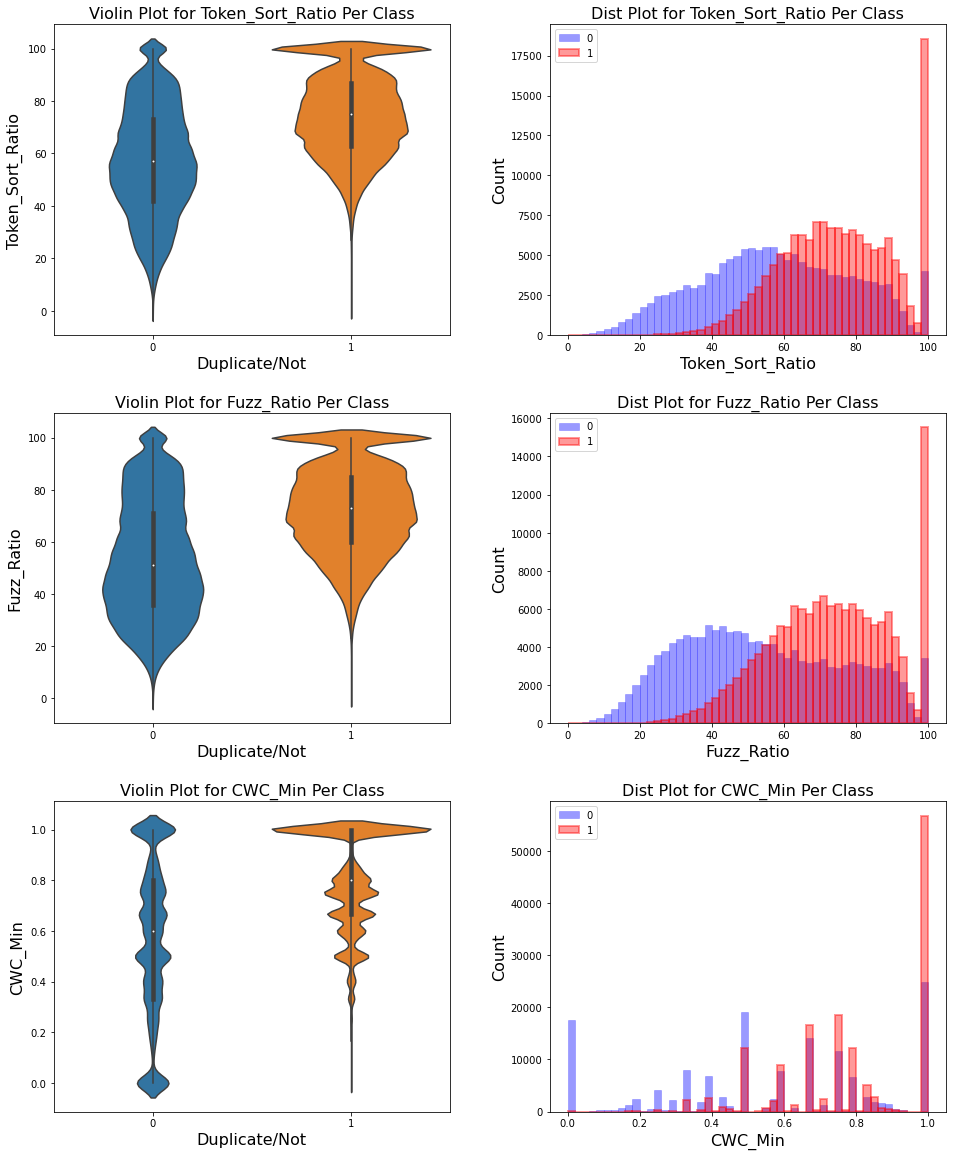

In [46]:
plt.figure(figsize=(16, 20))

plt.subplot(3,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Token_Sort_Ratio', data = data_adv2)
plt.title("Violin Plot for Token_Sort_Ratio Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Token_Sort_Ratio", fontsize = 16)

plt.subplot(3,2,2)
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 0]['Token_Sort_Ratio'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 1]['Token_Sort_Ratio'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Token_Sort_Ratio Per Class", fontsize = 16)
plt.xlabel("Token_Sort_Ratio", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(3,2,3)
sns.violinplot(x = 'is_duplicate', y = 'Fuzz_Ratio', data = data_adv2)
plt.title("Violin Plot for Fuzz_Ratio Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Fuzz_Ratio", fontsize = 16)

plt.subplot(3,2,4)
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 0]['Fuzz_Ratio'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 1]['Fuzz_Ratio'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Fuzz_Ratio Per Class", fontsize = 16)
plt.xlabel("Fuzz_Ratio", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(3,2,5)
sns.violinplot(x = 'is_duplicate', y = 'CWC_Min', data = data_adv2)
plt.title("Violin Plot for CWC_Min Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("CWC_Min", fontsize = 16)

plt.subplot(3,2,6)
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 0]['CWC_Min'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(data_adv2[data_adv2['is_duplicate'] == 1]['CWC_Min'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for CWC_Min Per Class", fontsize = 16)
plt.xlabel("CWC_Min", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplots_adjust(hspace = 0.25, wspace = 0.25)
plt.show()


### Observations:
- Both Violin Plots and dist plots clearly shows the separation between duplicate and non-duplicate questions.
- In the duplicate questions, the values of Fuzz_Ratio, Toke_Sort_Ratio and CWC_Min are higher as compared to non-duplicate questions.

## Plotting TSNE

In [47]:
data_adv2.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'Freq_qid1', 'Freq_qid2', 'Q1_len', 'Q2_len', 'Q1_n_words',
       'Q2_n_words', 'Word_Common', 'Word_Total', 'Word_Share',
       'Freq_q1+Freq_q2', 'Freq_q1-Freq_q2', 'CWC_Min', 'CWC_Max',
       'Last_Word_Equality', 'First_Word_Equality', 'Abs_Len_Diff', 'Mean_Len',
       'Fuzz_Ratio', 'Fuzz_Partial_Ratio', 'Token_Sort_Ratio',
       'Token_Set_Ratio', 'Longest_Substr_Ratio'],
      dtype='object')

In [48]:
data_adv_sub = data_adv2[['is_duplicate','Freq_qid1', 'Freq_qid2', 'Q1_len', 'Q2_len', 'Q1_n_words',
       'Q2_n_words', 'Word_Common', 'Word_Total', 'Word_Share',
       'Freq_q1+Freq_q2', 'Freq_q1-Freq_q2', 'CWC_Min', 'CWC_Max',
       'Last_Word_Equality', 'First_Word_Equality', 'Abs_Len_Diff', 'Mean_Len',
       'Fuzz_Ratio', 'Fuzz_Partial_Ratio', 'Token_Sort_Ratio',
       'Token_Set_Ratio', 'Longest_Substr_Ratio']]
data_adv_sub = data_adv_sub.sample(5000)
data_adv_sub.shape

(5000, 23)

In [49]:
data_adv_sub2 = data_adv_sub.drop('is_duplicate', axis = 1)
data_adv_sub2.shape

(5000, 22)

In [50]:
data_adv_sub_standardized = StandardScaler().fit_transform(data_adv_sub2)
print(data_adv_sub_standardized.shape)
print(type(data_adv_sub_standardized))

(5000, 22)
<class 'numpy.ndarray'>


[t-SNE] Computing 4999 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 7.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 3.022317
[t-SNE] Computed conditional probabilities in 28.454s
[t-SNE] Iteration 50: error = 36.9075890, gradient norm = 0.0000000 (50 iterations in 17.977s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 36.907589
[t-SNE] Iteration 100: error = 0.2193224, gradient norm = 0.0021277 (50 iterations in 17.395s)
[t-SNE] Iteration 150: error = 0.1436334, gradient norm = 0.0002766 (50 iterations in 17.535s)
[t-SNE] Iteration 200: err

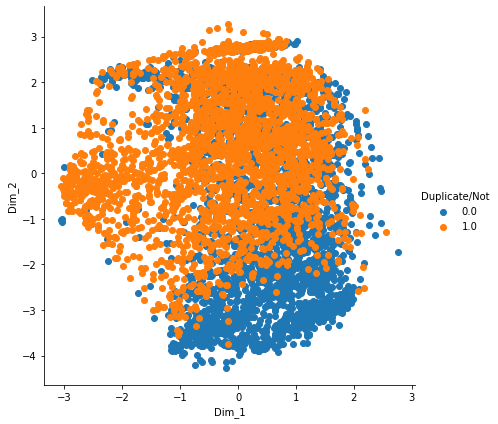

In [51]:
model = TSNE(n_components=2, random_state=0, perplexity=2500, n_iter=600, verbose=2)

tsne_data = model.fit_transform(data_adv_sub_standardized)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, data_adv_sub['is_duplicate'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Duplicate/Not"))
sns.FacetGrid(tsne_df, hue="Duplicate/Not", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


## Splitting data into Train, CV and Test in 70%, 12% and 18% respectively

In [52]:
data_adv2 = pd.read_csv(os.path.join(DATAPATH, DATA_ADV2))
data_adv2.head()

,id,qid1,qid2,question1,question2,is_duplicate,Freq_qid1,Freq_qid2,Q1_len,Q2_len,...,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Longest_Substr_Ratio
0,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,3,1,51,88,...,0.399996,0.0,0.0,5.0,7.5,62.0,94.0,62.0,89.0,0.838707
1,2,5,6,how can increas speed internet connect while u...,how can internet speed increas hack dns,0,1,1,73,59,...,0.555549,0.0,1.0,2.0,8.0,53.0,59.0,70.0,87.0,0.192307
2,3,7,8,whi mental lone how can solv,find remaind math math divid,0,1,1,50,65,...,0.000000,0.0,0.0,1.0,5.5,25.0,30.0,18.0,20.0,0.071428
3,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0,3,1,76,39,...,0.199998,0.0,0.0,5.0,7.5,24.0,50.0,43.0,53.0,0.109091
4,5,11,12,astrolog capricorn sun cap moon cap rise say,tripl capricorn sun moon ascend capricorn say,1,1,1,86,90,...,0.571420,1.0,0.0,1.0,7.5,72.0,70.0,67.0,77.0,0.340908


In [53]:
X_Train, Test, Y_Train, TestLabels = train_test_split(data_adv2, data_adv2['is_duplicate'], stratify=data_adv2['is_duplicate'], test_size=0.18)
Train, CV, TrainLabels, CVLabels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.14634)

In [54]:
print('Number of data points in train data:', Train.shape)
print('Train data labels shape:', TrainLabels.shape,'\n')

print('Number of data points in test data:', Test.shape)
print('Test data labels shape:', TestLabels.shape,'\n')

print('Number of data points in cross validation data:', CV.shape)
print('CV data labels shape:', CVLabels.shape,'\n')

Number of data points in train data: (208891, 28)
Train data labels shape: (208891,) 

Number of data points in test data: (53716, 28)
Test data labels shape: (53716,) 

Number of data points in cross validation data: (35810, 28)
CV data labels shape: (35810,) 



In [55]:
print("----------Distribution of output variable in train data----------")
print("Class 0: {}%          Class 1: {}%:\n".format((TrainLabels.value_counts()[0]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100, (TrainLabels.value_counts()[1]/(TrainLabels.value_counts()[0]+TrainLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in test data----------")
print("Class 0: {}%          Class 1: {}%:\n".format((TestLabels.value_counts()[0]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100, (TestLabels.value_counts()[1]/(TestLabels.value_counts()[0]+TestLabels.value_counts()[1]))*100))

print("----------Distribution of output variable in CV data----------")
print("Class 0: {}%          Class 1: {}%:".format((CVLabels.value_counts()[0]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100, (CVLabels.value_counts()[1]/(CVLabels.value_counts()[0]+CVLabels.value_counts()[1]))*100))

----------Distribution of output variable in train data----------
Class 0: 49.986835239431095%          Class 1: 50.013164760568905%:

----------Distribution of output variable in test data----------
Class 0: 49.986968501005286%          Class 1: 50.01303149899471%:

----------Distribution of output variable in CV data----------
Class 0: 49.98603741971516%          Class 1: 50.01396258028483%:


## Featurizing Question1 and Question2 by W2V

In [56]:
def listOfListSent(TrainText):
    listOfSentences = []
    for sentence in TrainText.values:
        subSentence = []
        for word in sentence.split():
            subSentence.append(word)  
        listOfSentences.append(subSentence)
    return listOfSentences


In [60]:
# 1. create w2v feature only for question1 in the order train,cv,test
# 2. create w2v feature only for question2 in the order train,cv,test

def create_w2v(df, which_df, which_ques):
    listOfSentences = listOfListSent(df[which_ques])
    if which_df == "Train":
        # compute average word2vec for each text in train data.
        w2vModel = gensim.models.Word2Vec(listOfSentences, min_count=5, workers=4)
        pickle.dump(w2vModel, open(os.path.join(DATAPATH, "w2vModel.sav"), 'wb'))
        train_text_feature_w2v = []
        for sentence in listOfSentences:
            sentenceVector = np.zeros(300)
            TotalWordsPerSentence = 0
            for word in sentence:
                try:
                    vect = w2vModel.wv[word]
                    sentenceVector += vect
                    TotalWordsPerSentence += 1
                except:
                    pass
            if TotalWordsPerSentence!= 0:
                sentenceVector /= TotalWordsPerSentence
            train_text_feature_w2v.append(sentenceVector)
        return train_text_feature_w2v
    else:
        # compute average word2vec for each text in cv and test data.
        w2vModelLoaded = pickle.load(open(os.path.join(DATAPATH, "w2vModel.sav"), 'rb'))
        cv_test_text_feature_w2v = []
        for sentence in listOfSentences:
            sentenceVector = np.zeros(300)
            TotalWordsPerSentence = 0
            for word in sentence:
                try:
                    vect = w2vModelLoaded.wv[word]
                    sentenceVector += vect
                    TotalWordsPerSentence += 1
                except:
                    pass
            if TotalWordsPerSentence!= 0:
                sentenceVector /= TotalWordsPerSentence
            cv_test_text_feature_w2v.append(sentenceVector)
        return cv_test_text_feature_w2v

In [61]:
w2vFeaturesTrainQuestion1 = create_w2v(Train, "Train", "question1")
w2vFeaturesCVQuestion1 = create_w2v(CV, "CV", "question1")
w2vFeaturesTestQuestion1 = create_w2v(Test, "Test", "question1")

w2vFeaturesTrainQuestion2 = create_w2v(Train, "Train", "question2")
w2vFeaturesCVQuestion2 = create_w2v(CV, "CV", "question2")
w2vFeaturesTestQuestion2 = create_w2v(Test, "Test", "question2")

print("Shape of w2vFeaturesTrainQuestion1 = {}".format(np.array(w2vFeaturesTrainQuestion1).shape))
print("Shape of w2vFeaturesCVQuestion1 = {}".format(np.array(w2vFeaturesCVQuestion1).shape))
print("Shape of w2vFeaturesTestQuestion1 = {}\n".format(np.array(w2vFeaturesTestQuestion1).shape))

print("Shape of w2vFeaturesTrainQuestion2 = {}".format(np.array(w2vFeaturesTrainQuestion2).shape))
print("Shape of w2vFeaturesCVQuestion2 = {}".format(np.array(w2vFeaturesCVQuestion2).shape))
print("Shape of w2vFeaturesTestQuestion2 = {}".format(np.array(w2vFeaturesTestQuestion2).shape))

Shape of w2vFeaturesTrainQuestion1 = (208891, 300)
Shape of w2vFeaturesCVQuestion1 = (35810, 300)
Shape of w2vFeaturesTestQuestion1 = (53716, 300)

Shape of w2vFeaturesTrainQuestion2 = (208891, 300)
Shape of w2vFeaturesCVQuestion2 = (35810, 300)
Shape of w2vFeaturesTestQuestion2 = (53716, 300)


In [62]:
Train_New = Train.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1, inplace = False)
CV_New = CV.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1, inplace = False)
Test_New = Test.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis = 1, inplace = False)

#-----------------------------Stacking Train Data and Saving it-----------------------------#
TrainFinal = np.hstack((Train_New.values, np.array(w2vFeaturesTrainQuestion1), np.array(w2vFeaturesTrainQuestion2)))
TrainFinalLabels = TrainLabels
print("Shape of Train Data = {}".format(TrainFinal.shape))
print("Shape of Train Labels = {}\n".format(TrainFinalLabels.shape))
pickle.dump(TrainFinal, open(os.path.join(DATAPATH, 'TrainFinal.sav'), 'wb'))
pickle.dump(TrainFinalLabels, open(os.path.join(DATAPATH, 'TrainFinalLabels.sav'), 'wb'))

#-----------------------------Stacking CV Data and Saving it-----------------------------#
CVFinal = np.hstack((CV_New.values, np.array(w2vFeaturesCVQuestion1), np.array(w2vFeaturesCVQuestion2)))
CVFinalLabels = CVLabels
print("Shape of CV Data = {}".format(CVFinal.shape))
print("Shape of CV Labels = {}\n".format(CVFinalLabels.shape))
pickle.dump(CVFinal, open(os.path.join(DATAPATH, 'CVFinal.sav'), 'wb'))
pickle.dump(CVFinalLabels, open(os.path.join(DATAPATH, 'CVFinalLabels.sav'), 'wb'))

#-----------------------------Stacking Test Data and Saving it-----------------------------#
TestFinal = np.hstack((Test_New.values, np.array(w2vFeaturesTestQuestion1), np.array(w2vFeaturesTestQuestion2)))
TestFinalLabels = TestLabels
print("Shape of Test Data = {}".format(TestFinal.shape))
print("Shape of Test Labels = {}\n".format(TestFinalLabels.shape))
pickle.dump(TestFinal, open(os.path.join(DATAPATH, 'TestFinal.sav'), 'wb'))
pickle.dump(TestFinalLabels, open(os.path.join(DATAPATH, 'TestFinalLabels.sav'), 'wb'))


Shape of Train Data = (208891, 622)
Shape of Train Labels = (208891,)

Shape of CV Data = (35810, 622)
Shape of CV Labels = (35810,)

Shape of Test Data = (53716, 622)
Shape of Test Labels = (53716,)



## Machine Learning Models

In [63]:
TrainFinal = pickle.load(open(os.path.join(DATAPATH, "TrainFinal.sav"), 'rb'))
TrainFinalLabels = np.array(pickle.load(open(os.path.join(DATAPATH, "TrainFinalLabels.sav"), 'rb')))
CVFinal = pickle.load(open(os.path.join(DATAPATH, "CVFinal.sav"), 'rb'))
CVFinalLabels = np.array(pickle.load(open(os.path.join(DATAPATH, "CVFinalLabels.sav"), 'rb')))
TestFinal = pickle.load(open(os.path.join(DATAPATH, "TestFinal.sav"), 'rb'))
TestFinalLabels = np.array(pickle.load(open(os.path.join(DATAPATH, "TestFinalLabels.sav"), 'rb')))

print("Shape of Train Data = {}".format(TrainFinal.shape))
print("Shape of Train Labels = {}\n".format(TrainFinalLabels.shape))
print("Shape of CV Data = {}".format(CVFinal.shape))
print("Shape of CV Labels = {}\n".format(CVFinalLabels.shape))
print("Shape of Test Data = {}".format(TestFinal.shape))
print("Shape of Test Labels = {}\n".format(TestFinalLabels.shape))

Shape of Train Data = (208891, 622)
Shape of Train Labels = (208891,)

Shape of CV Data = (35810, 622)
Shape of CV Labels = (35810,)

Shape of Test Data = (53716, 622)
Shape of Test Labels = (53716,)



In [64]:
# Plotting function for confusion matrix, precision matrix and recall matrix

def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    # confusionMatx = [[1, 2],
    #                  [3, 4]]
    # confusionMatx.T = [[1, 3],
    #                   [2, 4]]
    # confusionMatx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
    # confusionMatx.sum(axix =1) = [[3, 7]]
    # (confusionMatx.T)/(confusionMatx.sum(axis=1)) = [[1/3, 3/7]
    #                                                  [2/3, 4/7]]

    # (confusionMatx.T)/(confusionMatx.sum(axis=1)).T = [[1/3, 2/3]
    #                                                    [3/7, 4/7]]
    # sum of row elements = 1
    plt.figure(figsize=(25, 7))
    labels = [0, 1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Precision Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplot(1, 3, 3)
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title("Recall Matrix", fontsize = 20)
    plt.xlabel('Predicted Class', fontsize = 18)
    plt.ylabel('Original Class', fontsize = 18)
    plt.tick_params(labelsize = 18)
    
    plt.subplots_adjust(wspace = 0.25)
    plt.show()

### Creating Random Model

Log loss on Test Data using Random Model 0.8883952665369181


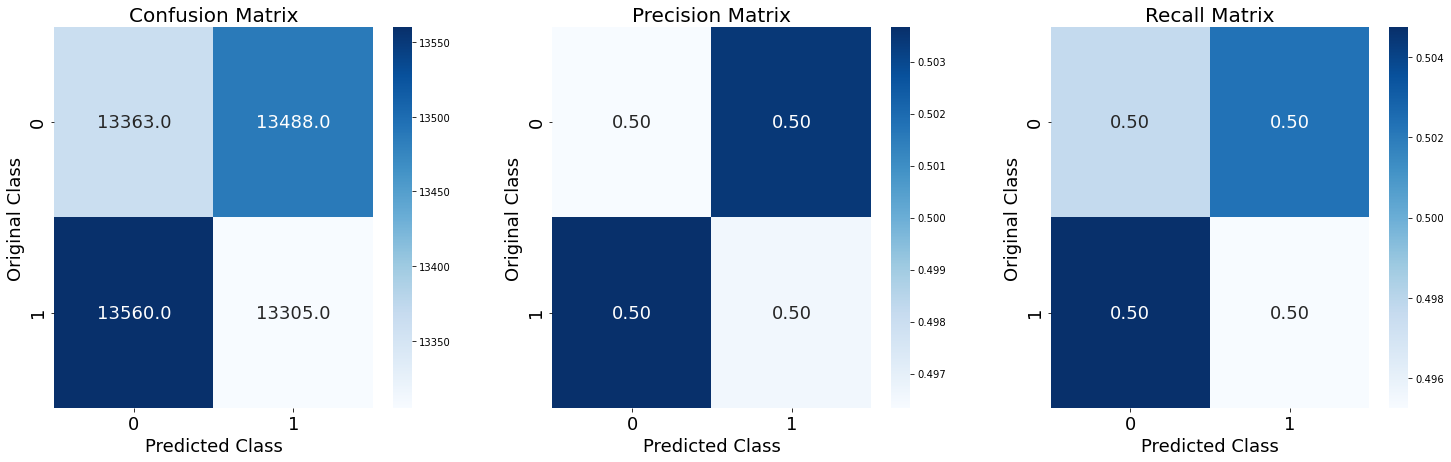

In [65]:
# we need to generate 2 numbers and the sum of numbers should be 1
# one solution is to genarate 2 numbers and divide each of the numbers by their sum
predicted = np.zeros((TestFinal.shape[0],2))
for i in range(TestFinal.shape[0]):
    rand_num = np.random.rand(1,2)
    predicted[i] = rand_num/sum(rand_num[0])
print("Log loss on Test Data using Random Model",log_loss(TestFinalLabels, predicted))
print_confusionMatrix(TestFinalLabels, np.argmax(predicted, axis = 1))

In [66]:
Log_Loss = []
Accuracy_Scores = []

## Logistic Regression

### Logistic Regression Hyper-parameter Tuning

For alpha value of 1e-05 CV log loss = 0.45928047825848056
For alpha value of 0.0001 CV log loss = 0.4484088344716962
For alpha value of 0.001 CV log loss = 0.4395524431273752
For alpha value of 0.01 CV log loss = 0.4483253377417437
For alpha value of 0.1 CV log loss = 0.48478654576786007
For alpha value of 1 CV log loss = 0.5189472491342166
For alpha value of 10 CV log loss = 0.5376363539387167
For alpha value of 100 CV log loss = 0.541364662696876


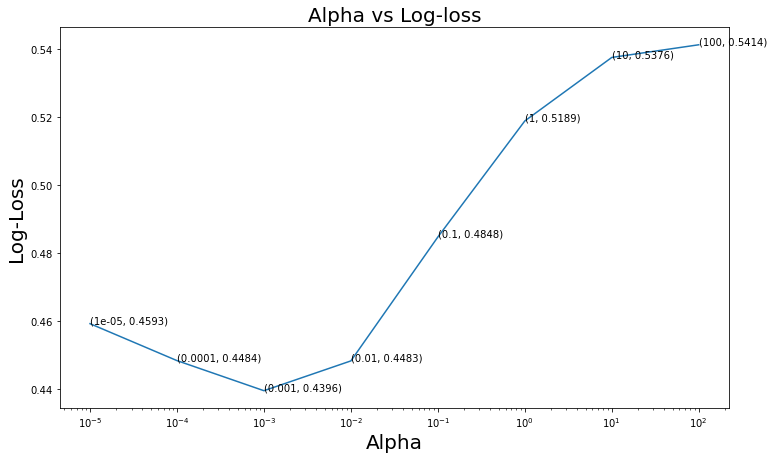

In [67]:
Scalar = StandardScaler()
Scalar.fit(TrainFinal)
TrainFinalStd = Scalar.transform(TrainFinal)
CVFinalStd = Scalar.transform(CVFinal)
TestFinalStd = Scalar.transform(TestFinal)

alpha = [10**x for x in range(-5, 3)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i)
    clf.fit(TrainFinalStd, TrainFinalLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(TrainFinalStd, TrainFinalLabels)
    predicted_y = calib_clf.predict_proba(CVFinalStd)
    cv_log_loss.append(log_loss(CVFinalLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CVFinalLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

## Logistic Regression with best Hyper-Parameter

For values of best alpha = 0.001, Test LogLoss = 0.4375847587818523, Test Accuracy Score = 77.89%


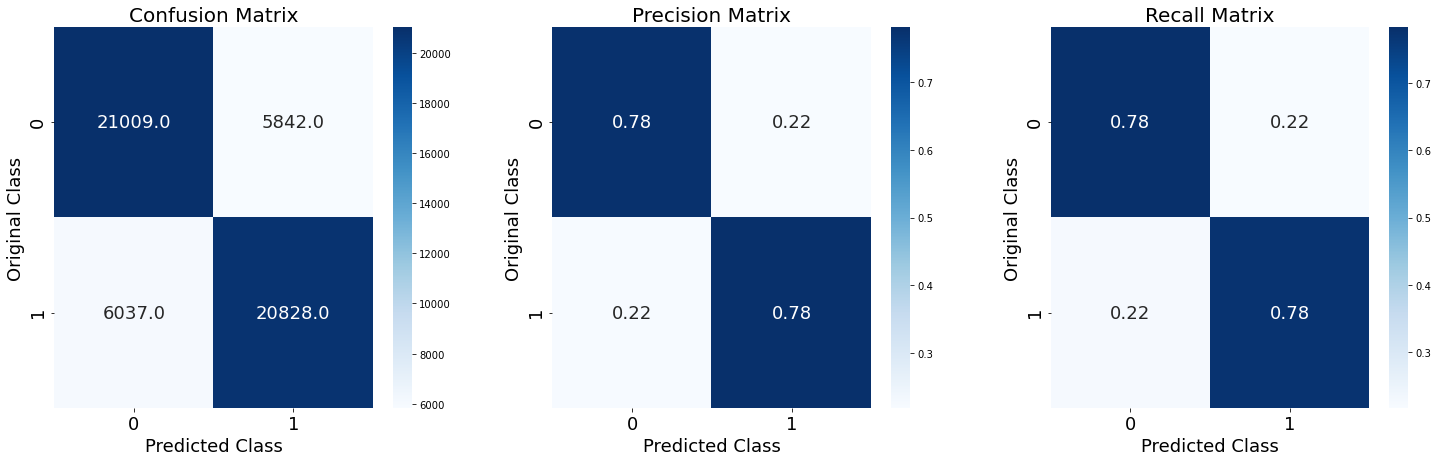

In [68]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(TrainFinalStd, TrainFinalLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(TrainFinalStd, TrainFinalLabels)

predict_test = calib_clf.predict_proba(TestFinalStd)
LR_LogLoss = log_loss(TestFinalLabels, predict_test)
LR_Accuracy = accuracy_score(TestFinalLabels, calib_clf.predict(TestFinalStd))
print('For values of best alpha = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_LogLoss, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, calib_clf.predict(TestFinalStd))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

## Support Vector Machines

### SVM Hyper-Parameter Tuning

For alpha value of 1e-05 CV log loss = 0.4590466844498418
For alpha value of 0.0001 CV log loss = 0.4567318059869188
For alpha value of 0.001 CV log loss = 0.4480532750733467
For alpha value of 0.01 CV log loss = 0.44442266853501033
For alpha value of 0.1 CV log loss = 0.47714058384470204
For alpha value of 1 CV log loss = 0.5141435720383893
For alpha value of 10 CV log loss = 0.5381531619628835
For alpha value of 100 CV log loss = 0.5418322558370879


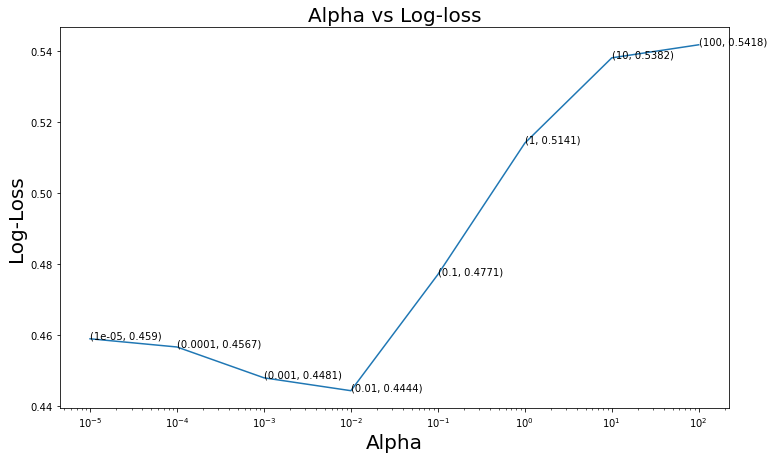

In [69]:
alpha = [10**x for x in range(-5, 3)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i)
    clf.fit(TrainFinalStd, TrainFinalLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(TrainFinalStd, TrainFinalLabels)
    predicted_y = calib_clf.predict_proba(CVFinalStd)
    cv_log_loss.append(log_loss(CVFinalLabels, predicted_y))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CVFinalLabels, predicted_y)))

plt.figure(figsize = (12, 7))
plt.xscale('log')
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

### SVM Fitting with best Hyper-Parameter

For values of best alpha = 0.01, Test LogLoss = 0.4436743886796465, Test Accuracy Score = 77.26%


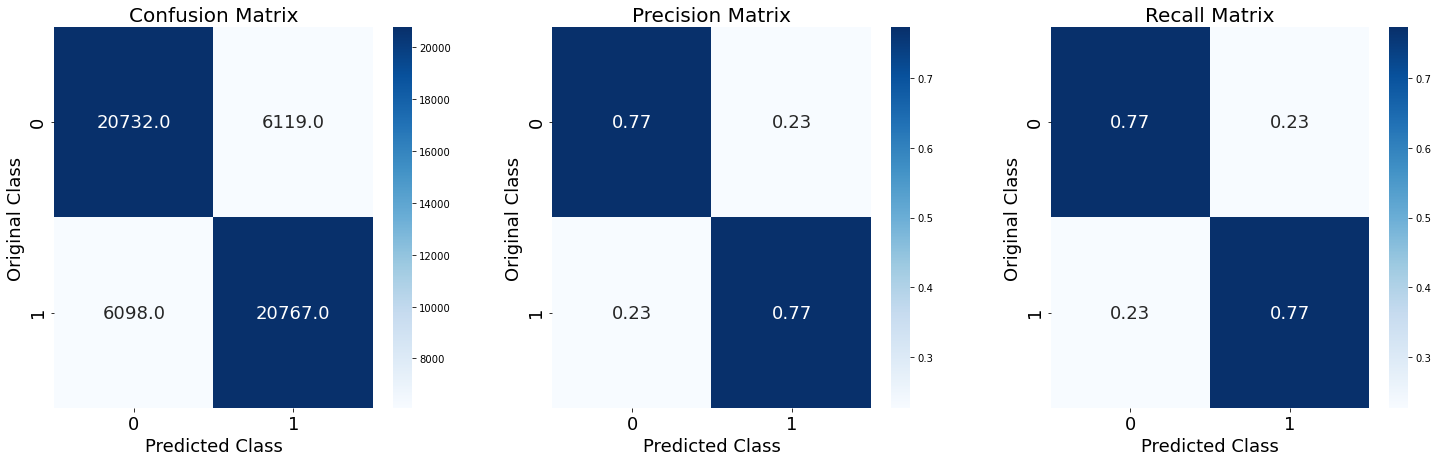

In [70]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "hinge", alpha = best_alpha)
clf.fit(TrainFinalStd, TrainFinalLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(TrainFinalStd, TrainFinalLabels)

predict_test = calib_clf.predict_proba(TestFinalStd)
LR_LogLoss = log_loss(TestFinalLabels, predict_test)
LR_Accuracy = accuracy_score(TestFinalLabels, calib_clf.predict(TestFinalStd))
print('For values of best alpha = {}, Test LogLoss = {}, Test Accuracy Score = {}%'.format(best_alpha, LR_LogLoss, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels, calib_clf.predict(TestFinalStd))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

## XGBoost

In [71]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(TrainFinal, label=TrainFinalLabels)
d_test = xgb.DMatrix(CVFinal, label=CVFinalLabels)

watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.68462	valid-logloss:0.68474
[10]	train-logloss:0.61392	valid-logloss:0.61466
[20]	train-logloss:0.56335	valid-logloss:0.56456
[30]	train-logloss:0.52495	valid-logloss:0.52649
[40]	train-logloss:0.49561	valid-logloss:0.49736
[50]	train-logloss:0.47312	valid-logloss:0.47500
[60]	train-logloss:0.45527	valid-logloss:0.45729
[70]	train-logloss:0.44118	valid-logloss:0.44335
[80]	train-logloss:0.42982	valid-logloss:0.43208
[90]	train-logloss:0.42075	valid-logloss:0.42308
[100]	train-logloss:0.41323	valid-logloss:0.41551
[110]	train-logloss:0.40706	valid-logloss:0.40937
[120]	train-logloss:0.40199	valid-logloss:0.40428
[130]	train-logloss:0.39774	valid-logloss:0.40008
[140]	train-logloss:0.39417	valid-logloss:0.39653
[150]	train-logloss:0.39120	valid-logloss:0.39359
[160]	train-logloss:0.38864	valid-logloss:0.39108
[170]	train-logloss:0.38650	valid-logloss:0.38898
[180]	train-logloss:0.38457	valid-logloss:0.38706
[190]	train-logloss:0.38283	valid-logloss:0.38530
[200]	train

Test LogLoss = 0.3697958804777555, Test Accuracy Score = 81.45%


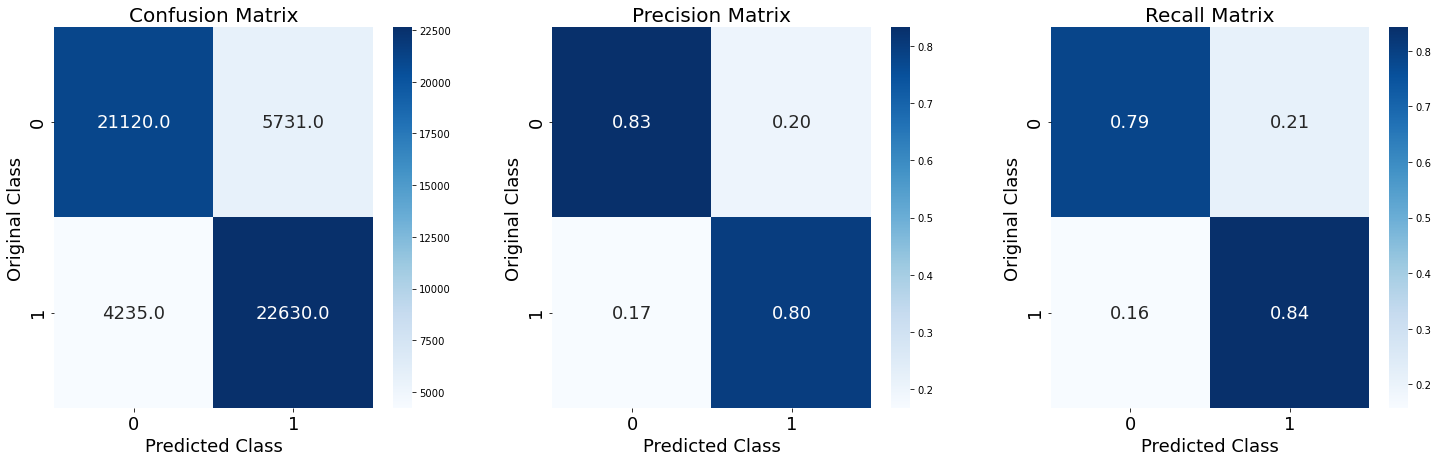

In [72]:
d_test = xgb.DMatrix(TestFinal)
LR_LogLoss = log_loss(TestFinalLabels, bst.predict(d_test))
LR_Accuracy = accuracy_score(TestFinalLabels, list(map(lambda x: int(x>0.5), bst.predict(d_test))))
print('Test LogLoss = {}, Test Accuracy Score = {}%'.format(LR_LogLoss, round((float(LR_Accuracy))*100,2)))
print_confusionMatrix(TestFinalLabels,  list(map(lambda x: int(x>0.5), bst.predict(d_test))))

Log_Loss.append(LR_LogLoss)
Accuracy_Scores.append(LR_Accuracy)

In [73]:
df = pd.DataFrame({
    'Model': ["Logistic Regression", "SVC", "XGBoost"], 
    'Accuracy': Accuracy_Scores,
    'Log-Loss': Log_Loss
})
df

,Model,Accuracy,Log-Loss
0,Logistic Regression,0.778855,0.437585
1,SVC,0.772563,0.443674
2,XGBoost,0.814469,0.369796


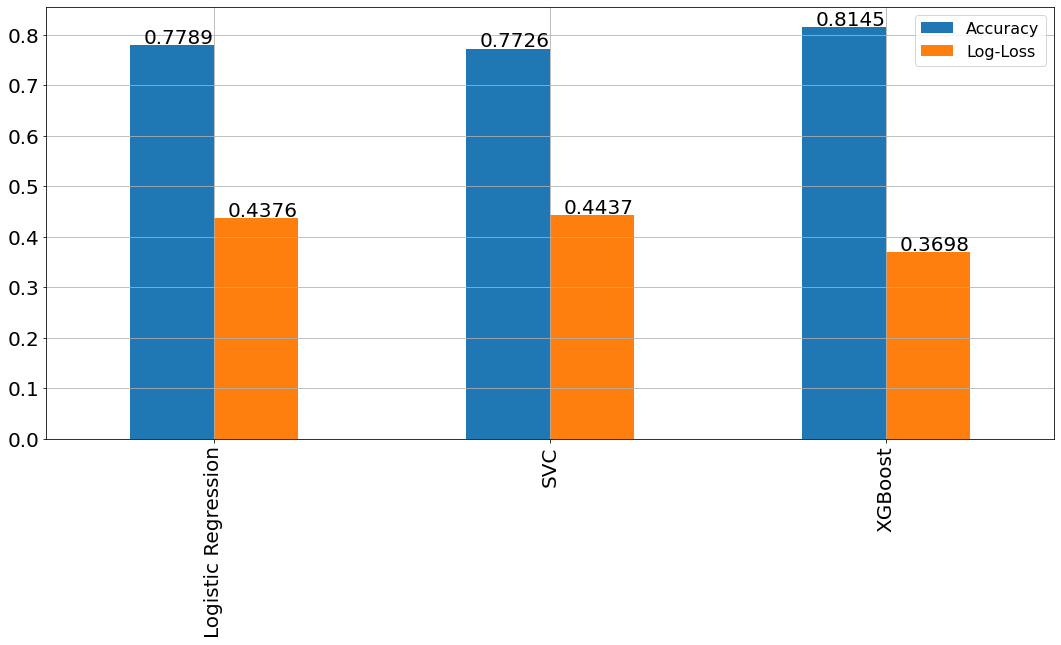

In [74]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,1,1])
df.plot(x = 'Model', y = ['Accuracy', 'Log-Loss'], figsize = (14, 6), kind = 'bar', ax = axes, grid = True)
plt.legend(fontsize = 16)
axes.set_xlabel("")
axes.tick_params(labelsize = 20)
for i in axes.patches:
    axes.text(i.get_x()+0.04, i.get_height()+0.003, str(round(i.get_height(), 4)), fontsize=20, color='black')
plt.show()

# XGBoost turns out to be the best performing model.